In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
traindf=pd.read_csv("data/train.csv")

In [3]:
traindf.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
traindf.shape

(7613, 5)

In [10]:
traindf['text'].duplicated().sum()

110

In [12]:

# dropping the duplicates
traindf.drop_duplicates('text', keep='first')
traindf.shape

(7613, 5)

<AxesSubplot:>

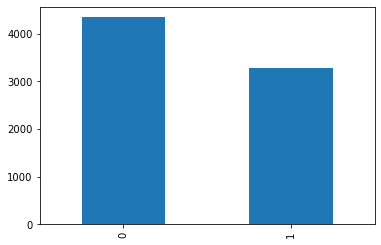

In [5]:

# checking the target distribution
traindf.target.value_counts().plot(kind = 'bar')

In [6]:
# checking some of the positive disaster tweets
for i in range(5):
  print(traindf[traindf.target==1]['text'].iloc[i])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 


In [7]:

# checking some of the neagtive disaster tweets
for i in range(5):
  print(traindf[traindf.target==0]['text'].iloc[i])

What's up man?
I love fruits
Summer is lovely
My car is so fast
What a goooooooaaaaaal!!!!!!


In [8]:

# Exploring the text lengths
textlen = traindf['text'].apply(lambda x: len(x.split()))

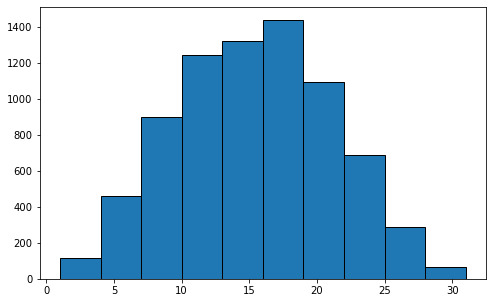

In [9]:

# vsualize the text length
import seaborn as sns
plt.figure(figsize=(8,5))
plt.hist(textlen, edgecolor = "black");

In [10]:

SEQ_LEN = 30

In [11]:
## FINE TUNING
from transformers import BertTokenizer
from transformers import AutoTokenizer
import tensorflow as tf

In [32]:
#!pip install tensorflow

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [13]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []

    for t in text.split(" "):
        t = '' if t.startswith('@') and len(t) > 1 else t
        t = '' if t.startswith('http') else t
        t = t.replace("#","")
        new_text.append(t.lower())
    return " ".join(new_text).strip().replace("  ", " ")

In [14]:
traindf['text'] = traindf['text'].apply(preprocess)
traindf.head()
     

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask. canada,1
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive wildfires evacuation ord...",1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1


In [15]:
# example of tokenization
tokenizer.tokenize(preprocess("Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all"))
     


['our',
 'deeds',
 'are',
 'the',
 'reason',
 'of',
 'this',
 'earthquake',
 'may',
 'allah',
 'forgive',
 'us',
 'all']

In [16]:
# example of an output from encoded text by tokeneizer
encoded_input = tokenizer(preprocess("Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all"))
print(encoded_input)
     

{'input_ids': [101, 2256, 15616, 2024, 1996, 3114, 1997, 2023, 8372, 2089, 16455, 9641, 2149, 2035, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [17]:
tokenizer.decode(encoded_input['input_ids'])

'[CLS] our deeds are the reason of this earthquake may allah forgive us all [SEP]'

In [18]:
# encoding the training data
train_encoded_inputs = tokenizer(traindf['text'].tolist(),
                                 add_special_tokens = True,
                                 padding='max_length', 
                                 truncation=True, 
                                 max_length=SEQ_LEN, 
                                 return_token_type_ids=False,
                                 return_tensors = 'tf')

In [19]:
train_encoded_inputs

{'input_ids': <tf.Tensor: shape=(7613, 30), dtype=int32, numpy=
array([[  101,  2256, 15616, ...,     0,     0,     0],
       [  101,  3224,  2543, ...,     0,     0,     0],
       [  101,  2035,  3901, ...,     0,     0,     0],
       ...,
       [  101, 23290,  1012, ...,     0,     0,     0],
       [  101,  2610, 11538, ...,  1012,   102,     0],
       [  101,  1996,  6745, ...,     0,     0,     0]])>, 'attention_mask': <tf.Tensor: shape=(7613, 30), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_encoded_inputs, traindf['target'].values))

In [22]:


# formatting the data as required by bert model
def map_bert(inputs, labels):
  inputs = {'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask']}
  
  return inputs, labels

In [23]:

train_dataset = train_dataset.map(map_bert)

In [24]:

for t in train_dataset.take(2):
  print (t)
     

({'input_ids': <tf.Tensor: shape=(30,), dtype=int32, numpy=
array([  101,  2256, 15616,  2024,  1996,  3114,  1997,  2023,  8372,
        2089, 16455,  9641,  2149,  2035,   102,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0])>, 'attention_mask': <tf.Tensor: shape=(30,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])>}, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
({'input_ids': <tf.Tensor: shape=(30,), dtype=int32, numpy=
array([  101,  3224,  2543,  2379,  2474,  6902,  3351, 21871,  2243,
        1012,  2710,   102,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0])>, 'attention_mask': <tf.Tensor: shape=(30,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])>}, <tf.Tensor:

In [25]:

dataset = train_dataset.shuffle(100000).batch(64)

In [26]:
# length of the dataset(total batches)
DS_LEN = len(dataset)
DS_LEN
     

119

In [27]:

# take 80% for train and 20% for validation
SPLIT = 0.8
train_ds = dataset.take(round(DS_LEN*SPLIT))
val_ds = dataset.skip(round(DS_LEN*SPLIT))
     

In [28]:
from transformers import TFAutoModel

In [29]:
bert = TFAutoModel.from_pretrained('bert-base-uncased')

C:\ProgramData\Anaconda3\envs\dsmlopsenv\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rajes\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- 

In [31]:
#create model architecture
#n_classes = len((train_df.target.unique()))

# Input layers
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), dtype=np.int32, name='input_ids' )
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), dtype=np.int32, name = 'attention_mask')

# bert embeddings
embeddings = bert([input_ids, mask])[0]
cls_token = embeddings[:,0,:]

# keras layers
#x = tf.keras.layers.GlobalMaxPool1D()(embeddings)
x = tf.keras.layers.BatchNormalization()(cls_token)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)

# output layer
y = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# create the model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

In [32]:

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 30)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 30,                                            

In [33]:

# freezing the pretrained bert layer
model.layers[2].trainable = False
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 30)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 30,                                            

In [34]:
import transformers

In [35]:
#learning_rate = 1e-3

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
#optimizer = transformers.AdamWeightDecay(learning_rate=5e-4)
loss = tf.keras.losses.BinaryCrossentropy()
metric = tf.keras.metrics.BinaryAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
     

In [39]:

# train the model
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.1,min_delta=0.001,monitor='val_loss'),
             tf.keras.callbacks.EarlyStopping(patience=5, min_delta=0.001, monitor='val_loss')]

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 2,
    callbacks = callbacks
)
     

Epoch 1/2
95/95 [==============================] - 231s 2s/step - loss: 0.4648 - accuracy: 0.7906 - val_loss: 0.4340 - val_accuracy: 0.8304 - lr: 5.0000e-04
Epoch 2/2
95/95 [==============================] - 233s 2s/step - loss: 0.4545 - accuracy: 0.7931 - val_loss: 0.4001 - val_accuracy: 0.8356 - lr: 5.0000e-04


In [37]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


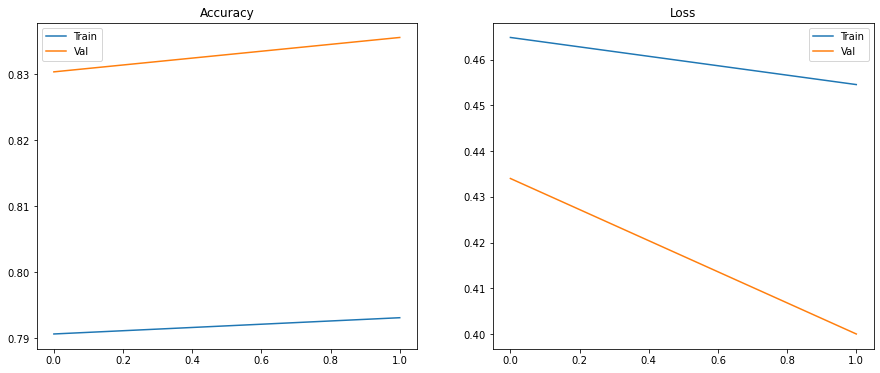

In [40]:
# plot the performance curve
epochs = history.epoch
plt.figure(figsize=(15, 6))

# Accuracy
plt.subplot(1,2, 1)
plt.plot(epochs, history.history['accuracy'], label="Train")
plt.plot(epochs, history.history['val_accuracy'], label = "Val")
plt.legend()
plt.title("Accuracy")

# loss
plt.subplot(1,2, 2)
plt.plot(epochs, history.history['loss'], label="Train")
plt.plot(epochs, history.history['val_loss'], label = "Val")
plt.legend()
plt.title("Loss")

plt.show()

In [41]:
# evaluate on val data
model.evaluate(val_ds)

24/24 [==============================] - 40s 2s/step - loss: 0.3927 - accuracy: 0.8382


[0.3926597535610199, 0.8382257223129272]

In [ ]:
test_df = pd.read_csv('test.csv')